# Preamable

> Download and extract data for notebook execution.

The cell below prepares the Google Colab environment for execution. It will download our dataset and the FLIM-Weights, which we will use in the following notebook (2_flim_unet.ipynb).

In [ ]:
import requests
from io import BytesIO
from zipfile import ZipFile
import os

def download_and_extract_zip(url, extract_path):
  response = requests.get(url, stream=True)
  response.raise_for_status()  # Raise an exception for bad status codes

  with ZipFile(BytesIO(response.content)) as zip_file:
    zip_file.extractall(extract_path)

if not os.path.exists("./parasites"):
  google_drive_url = "https://drive.usercontent.google.com/download?id=1Uwi8LYXYNnCp2brnuD49JrrWTrv_2HII&export=download&authuser=2&confirm=yes"
  download_and_extract_zip(google_drive_url, "./")
else:
  print("[INFO] Data already downloaded")

# Introduction to Parasite Egg Segmentation

> This notebook covers the necessary steps to experiment with a simple U-Net architecture, visualizing its activations.

We will approach the following:

1. Split our data into training and testing;
2. Configure a dataset;
3. Configure our dataset as a data loader to provide data ingestion during the training phase;
4. Define a fully convolutional network (U-Net);
5. Define a training loop and train our model;
6. Define a testing loop, load our best model, and test it.

## 1. Split data into training and testing sets

First, we will define our dataset and then explore the parasite egg dataset towards 2D segmentation. The eggs are from Schistosoma Mansoni. The cell below imports the necessary libraries.

In [ ]:
# Necessary libraries
from pathlib import Path, PosixPath
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch

First, we need to define the path to our dataset. We are using the reshaped parasite dataset (images and labels have a shape of 240x240 pixels with three channels). To run our experiments, we need to use either a GPU ("cuda") or a CPU ("cpu"); for such, we set the DEVICE variable.

Also, we will set up a folder to save our outputs (models and predictions).

Here, we also set the number of training epochs, our learning rate, and a loss function.

In [ ]:
DATA_PATH = Path("parasites/data")
ORIG_PATH = DATA_PATH / Path("orig")
LABELS_PATH = DATA_PATH / Path("label")
DEVICE = "cuda"

MODEL_FOLDER = Path("sample_plain_model")

# Training parameters
EPOCHS=50
LR=1e-2
LOSS="dice_focal"

Get the paths for all images and labels:

In [ ]:
images = os.listdir(ORIG_PATH)
images.sort()
# Labels have the same filename of images but in a different folder.
labels = images

Let us first understand our problem. To this end, we define the method `plot_image_with_label` to visualize an image and the mask of the parasite egg if it is present in the image.

In [ ]:
# Method to plot original and label images
def plot_image_with_label(image, label):
    image_path = ORIG_PATH / Path(image)
    label_path = LABELS_PATH / Path(label)

    image = Image.open(image_path)
    label = Image.open(label_path)

    print(f"[Image] Format: {image.format} | Size: {image.size} | Mode: {image.mode}")
    print(f"[Label] Format: {label.format} | Size: {label.size} | Mode: {label.mode}")

    plt.subplot(121)
    plt.yticks([]),plt.xticks([])
    plt.title("Image")
    plt.imshow(image)
    plt.subplot(122)
    plt.yticks([]),plt.xticks([])
    plt.title("Label")
    plt.imshow(label, cmap="gray")

[Image] Format: PNG | Size: (400, 400) | Mode: RGB
[Label] Format: PNG | Size: (400, 400) | Mode: L


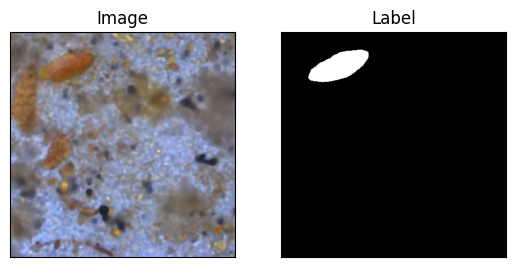

In [ ]:
# Image idx to visualize
idx = 7
plot_image_with_label(image=images[idx], label=labels[idx])

> Play with the idx parameter to visualize different images.

Our dataset contains 100 images. We will further divide it into training and testing images. We will use 70% to train (70) and 30% to test (30) the model.

In [ ]:
print(f"N images {len(images)}")

# 70% of train and 30% of test
n_train = int((0.7 * len(images)))

# Train Data (File Names)
train_images = images[:n_train]
train_labels = images[:n_train]
# Test Data (File Names)
test_images = images[n_train:]
test_labels = images[n_train:]

print(f"{len(train_images)} training images")
print(f"{len(test_images)} testing images")

N images 100
70 training images
30 testing images


## 2. Configure a dataset

Now, we need to define the Dataset class. It must:

- Enable training and testing with a single image (If we want to train with a single image - Simulate Overfit). In this case, we set the parameter `image_id` to a number (e.g., 0);
- Enable training and testing using the data splits. In this case, we set the parameter `image_id` to `None`.

We start by importing the necessary libraries.

In [ ]:
# First we import the necessary libraries to
from torch.utils.data import Dataset
from typing import List, Union
from torchvision import transforms
from torchvision.transforms import InterpolationMode
import numpy as np
from torch.utils.data import DataLoader
from PIL import ImageOps

Then, we define our dataset class:

In [ ]:
class SegDataset(Dataset):
    def __init__(
        self,
        images_path: PosixPath, # Path to images
        labels_path: PosixPath, # Path to labels
        images: List[str], # List of images
        labels: List[str], # List of labels
        image_id: int = None # Image ID if training with a single image
    ):
        self.images_path = [images_path / Path(image) for image in images]
        self.labels_path = [labels_path / Path(label) for label in labels]
        self.image_id = image_id

        """Transform input images to normalized tensors.
        [0, 255] -> [0, 1]
        """
        self.image_transforms = transforms.ToTensor()
        self.label_transforms = transforms.ToTensor()

    def __len__(self):
        # If image id not provided, we are training with all data
        if self.image_id == None:
            return len(self.images_path)
        else:
            return 1

    def __getitem__(self, idx):
        if self.image_id == None:
            image_path = self.images_path[idx]
            label_path = self.labels_path[idx]
        else:
            image_path = self.images_path[self.image_id]
            label_path = self.labels_path[self.image_id]

        image = self.image_transforms(Image.open(image_path))
        label = ImageOps.grayscale(Image.open(label_path))
        label = self.label_transforms(label)

        return image, label

Now, we create our dataset and a method (`visualize_dataset_item`) to visualize our dataset's given data (input image and label). The `__getitem__` method enables us to use our dataset to read a given image and label (`idx` parameter).

In [ ]:
# DATASETS - TRAIN AND TEST
train_dataset = SegDataset(
    images_path=ORIG_PATH,
    labels_path=LABELS_PATH,
    images=train_images,
    labels=train_labels,
    image_id=None
)
test_dataset = SegDataset(
    images_path=ORIG_PATH,
    labels_path=LABELS_PATH,
    images=test_images,
    labels=test_labels,
    image_id=None
)

In [ ]:
def visualize_dataset_item(dataset, item):
    img, label = dataset.__getitem__(item)
    img = img.permute(1, 2, 0)
    print("Foreground shape => ", img.shape)
    print("label shape => ", label.shape)

    plt.subplot(121)
    plt.yticks([]),plt.xticks([])
    plt.title("Image")
    plt.imshow(img)
    plt.subplot(122)
    plt.yticks([]),plt.xticks([])
    plt.title("Label")
    plt.imshow(label[0], cmap="gray", vmin=0, vmax=1)

Foreground shape =>  torch.Size([400, 400, 3])
label shape =>  torch.Size([1, 400, 400])


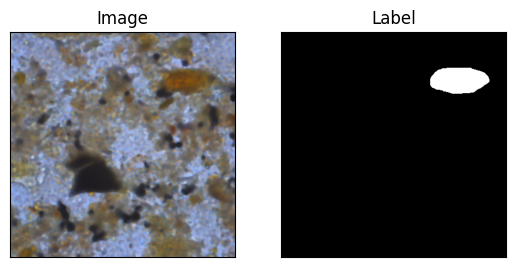

In [ ]:
visualize_dataset_item(
    dataset=train_dataset,
    item=60
)

## 3. Configure our dataset as a dataloader

Finally, through PyTorch data loader ([`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)), we configure our dataset as a data loader by using:

- A Dataset (Our Train and Test datasets);
- A batch size (Number of images used to update the model's parameters);
- If we want to shuffle our data at each epoch (We see images in different orders for each epoch).

In [ ]:
# DATALOADERS - TRAIN AND TEST
train_dataloader = DataLoader(
    train_dataset, batch_size=8, shuffle=True
)
test_dataloader  = DataLoader(
    test_dataset, batch_size=1, shuffle=False
)

Let us visualize a batch of input training data:

In [ ]:
def visualize_batch(dataloader):
    batch_images, batch_labels = next(iter(dataloader))
    batch_size = batch_images.shape[0]

    fig, axes = plt.subplots(batch_size, 2, figsize=(8,30))
    for idx in range(batch_size):
        image = batch_images[idx]
        label = batch_labels[idx]
        image = image.permute(1, 2, 0)

        # Plot Data
        axes[idx][0].set_yticks([]),axes[idx][0].set_xticks([])
        axes[idx][0].set_title("Image")
        axes[idx][0].imshow(image)
        axes[idx][1].set_yticks([]),axes[idx][1].set_xticks([])
        axes[idx][1].set_title("Label")
        axes[idx][1].imshow(label[0], cmap="gray", vmin=0, vmax=1)

In [ ]:
# Visualizes shape of a batch sampled from train dataloder
sample_train_images, sample_train_labels = next(iter(train_dataloader))
print("Images shape => ", sample_train_images.shape)
print("Labels shape => ", sample_train_labels.shape)

Images shape =>  torch.Size([8, 3, 400, 400])
Labels shape =>  torch.Size([8, 1, 400, 400])


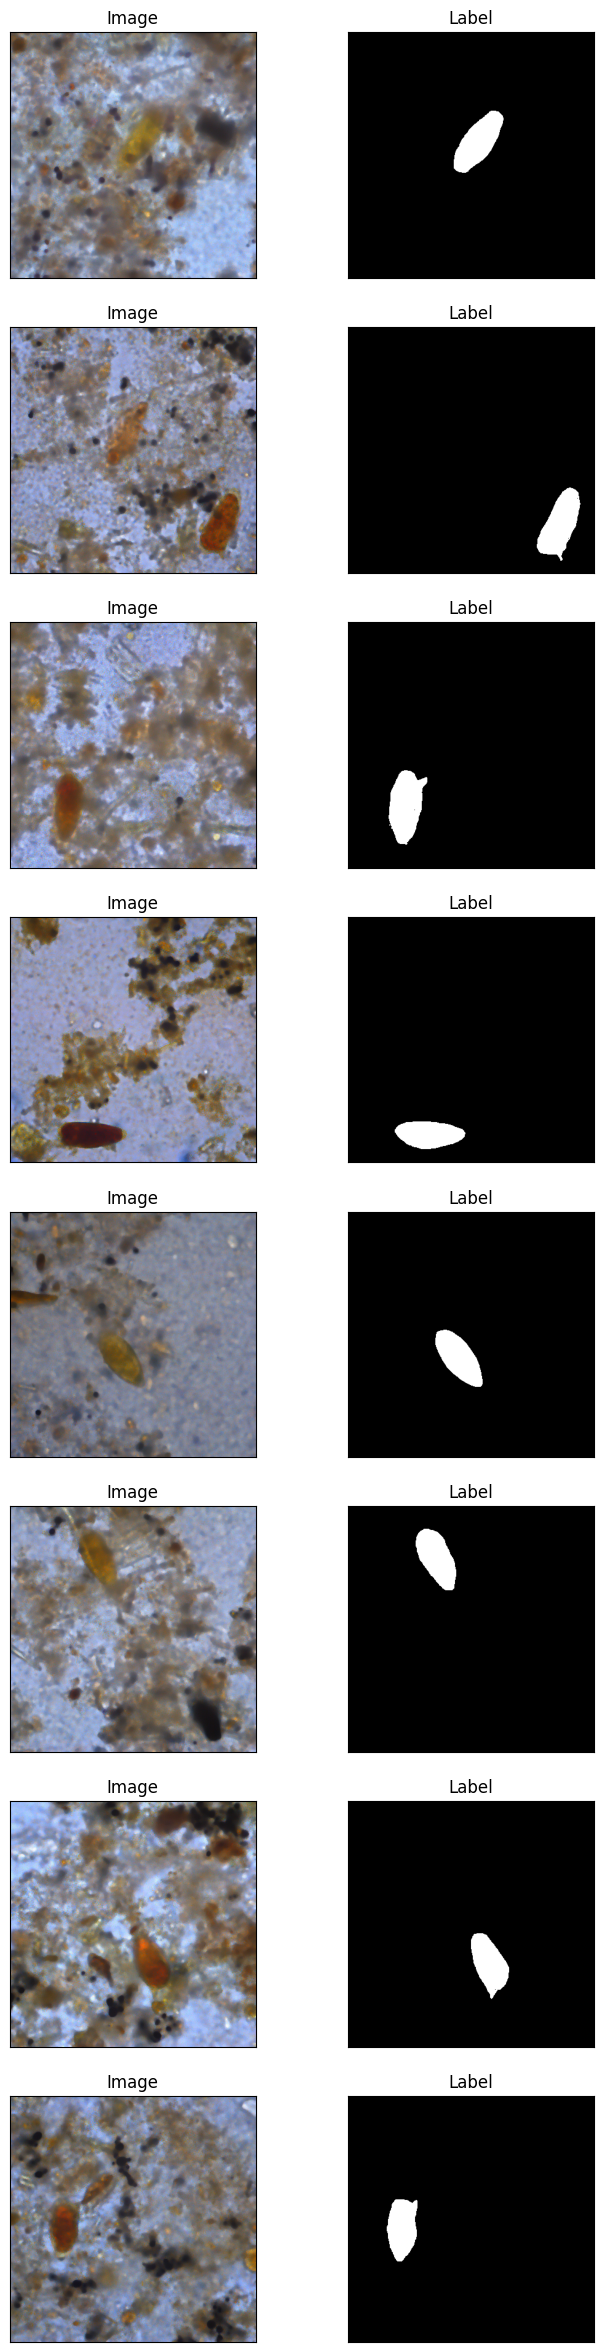

In [ ]:
visualize_batch(dataloader=train_dataloader)

## 4. Define a fully convolutional network (U-Net)

Now, we have a dataloader working. It is responsible for feeding data, both the input image and the parasite egg's segmentation mask, to a deep learning model. Given an input image, we expect that our model will learn to segment the parasite egg, if any.

The following cells define our deep-learning model, a U-Net architecture (**see the image below**). We also enable our model to store the activation maps for visual analysis.

> TODO: Experiment with different architectures, enable the model to save activation maps, and inspect them to see what the model learns.

U-Net architectures have two parts: an encoder (left) and a decoder (right). The encoder extracts image features at different levels while the encoder combines those extracted features to detect and segment.

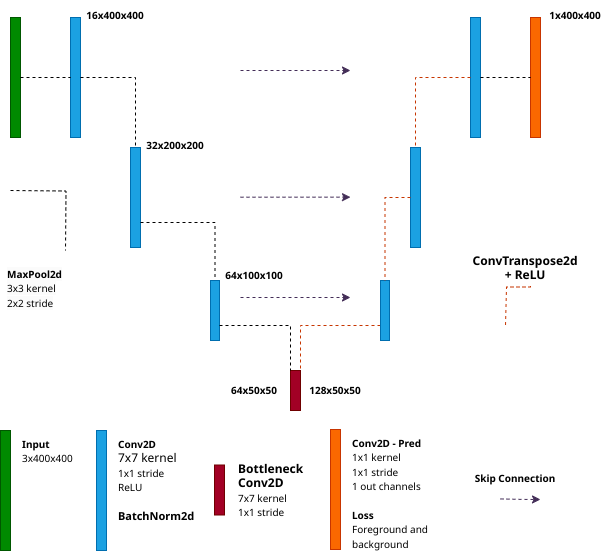

First, we import necessary libraries.

In [ ]:
import torch
from torch import nn
from tifffile import imsave

Let us first define some methods to help us:

- **up_conv:** Implements our **ConvTranspose2d** convolutions, responsible for upsampling our features in the decoder;
- **Conv:** Implements our **Conv2D** in decoders;
- **init_weights:** Initializes our model's parameters, using Xavier uniform for convolution's weights and setting biases to 0.01.

In [ ]:
# Upsamples input feature map
def get_up_conv(in_channels, out_channels, kernel_size=2, padding=0, stride=2, output_padding=0):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride, output_padding=output_padding),
        nn.ReLU(inplace=True)
    )

# Defines convolutional blocks for our decoder
def get_conv_block(in_channels, out_channels, kernel_size, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

# Initializes kernel weights
def init_weights(m):
    if (isinstance(m,nn.Conv2d) or (isinstance(m,nn.ConvTranspose2d))):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)

Now, the class UNet defines our U-Net architecture:

1. On the **__init__** method, we first set a random_seed to guarantee reproducibility. Then, we define our encoder blocks (block1, block2, and block3), our bottleneck, and finally, our decoder (up_convs + dec_convs and the pred convolution, which outputs our segmentation mask);
2. Our **forward** method is responsible for passing the input image through the model architecture until we get the parasite egg's mask at the end;
3. **write_activation** and **save_activations** saves activations of each network block for visual inspection (If we set the `activations_path`. If `activations_path` is `None`, it will not save, to avoid excessive disk usage, and decrease training times);
4. **save_curves** will save the learning curves of our models at the end of our training loop, displaying accuracy, loss, and dice across the whole training (save the curvers to the path indicated by `model_folder`);
5. **save_model_weights** save the model weights a `model_folder`;
6. **load_best_model** loads the best-trained model (i.e., lower loss).

To initialize a U-Net model, we must set the following parameters:

- `in_channels:` The number of channels of our input (e.g., 3 for RGB and 1 for Gray);
- `n_kernels:` A list of 3 integer values specifying the number of kernels for each convolutional block (e.g., [8, 16,32]). Those values are used to define both encoder and decoder convolutional blocks;
- `kernel_sizes:` A list of 3 integer values, specifying the kernels' size for each convolutional block (e.g., [3, 3, 3]);
- `model_folder`: An output folder to save model weights and learning curves;
- `activations_path:` A path to save each convolutional block activation. After training, one could navigate to that folder to visualize what features the model is extracting. If `None`, does not save activations.

> IMPORTANT: Saving activations increases training time, so it could be turned off by not setting the `activations_path` or setting it as `None` (Standard Value).

In [ ]:
class UNet(nn.Module):
    def __init__(
            self, in_channels: int, # RGB or LAB -> 3 Channels
            n_kernels: List[int], # N Kernels by conv block
            kernel_sizes: List[int], # Kernel sizes by conv block
            bottleneck_size: int, # Kernel size for bottleneck
            model_folder: PosixPath, # Path to save model weights and learning curves
            activations_path: PosixPath = None # Path to save activations
    ) -> None:
        super().__init__()

        # Sets torch seed to guaratee Reproducibility
        random_seed = 7
        torch.manual_seed(random_seed)
        torch.cuda.manual_seed(random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        self.activations_path = activations_path
        self.model_folder = model_folder
        os.makedirs(self.model_folder, exist_ok=True)
        self.weights_folder = model_folder / Path("weights")
        os.makedirs(self.weights_folder, exist_ok=True)

        # Encoder Convolutional Blocks
        self.block1 = get_conv_block(
            in_channels=in_channels,
            out_channels=n_kernels[0],
            kernel_size=kernel_sizes[0],
            padding=kernel_sizes[0] // 2
        )
        self.block2 = get_conv_block(
            in_channels=n_kernels[0],
            out_channels=n_kernels[1],
            kernel_size=kernel_sizes[1],
            padding=kernel_sizes[1] // 2
        )
        self.block3 = get_conv_block(
            in_channels=n_kernels[1],
            out_channels=n_kernels[2],
            kernel_size=kernel_sizes[2],
            padding=kernel_sizes[2] // 2
        )
        self.max_pool = nn.MaxPool2d(
            kernel_size=3, stride=2, padding=1
        )

        # Bottleneck
        self.bottleneck = nn.Conv2d(
            in_channels=n_kernels[2], out_channels=2*n_kernels[2],
            kernel_size=bottleneck_size, stride=1, padding=bottleneck_size//2
        )

        # Decoder
        self.up_conv1 = get_up_conv(
            in_channels=2*n_kernels[2], out_channels=n_kernels[2]
        )
        self.dec_conv1 = get_conv_block(
            in_channels=2*n_kernels[2], out_channels=n_kernels[2],
            kernel_size=kernel_sizes[2], padding=kernel_sizes[2] // 2
        )
        self.up_conv2 = get_up_conv(
            in_channels=n_kernels[2], out_channels=n_kernels[1]
        )
        self.dec_conv2 = get_conv_block(
            in_channels=2*n_kernels[1], out_channels=n_kernels[1],
            kernel_size=kernel_sizes[1], padding=kernel_sizes[1] // 2
        )
        self.up_conv3 = get_up_conv(
            in_channels=n_kernels[1], out_channels=n_kernels[0]
        )
        self.dec_conv3 = get_conv_block(
            in_channels=2*n_kernels[0], out_channels=n_kernels[0],
            kernel_size=kernel_sizes[0], padding=kernel_sizes[0] // 2
        )
        self.pred = nn.Conv2d(
            in_channels=n_kernels[0], out_channels=1, kernel_size=1
        )

        # Initializes weights
        self.block1.apply(init_weights)
        self.block2.apply(init_weights)
        self.block3.apply(init_weights)
        self.up_conv1.apply(init_weights)
        self.dec_conv1.apply(init_weights)
        self.up_conv2.apply(init_weights)
        self.dec_conv2.apply(init_weights)
        self.up_conv3.apply(init_weights)
        self.dec_conv3.apply(init_weights)
        self.pred.apply(init_weights)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Dictionary to keep track of activations
        self.activations = {"encoder": [], "decoder": []}

        # Encoder
        x1 = self.block1(x)
        self.activations["encoder"].append(x1)
        x2 = self.block2(self.max_pool(x1))
        self.activations["encoder"].append(x2)
        x3 = self.block3(self.max_pool(x2))
        self.activations["encoder"].append(x3)

        # Bottleneck
        bottleneck = self.bottleneck(self.max_pool(x3))

        # Decoder - torch.cat performs skip connections on decoder
        x = self.up_conv1(bottleneck)
        x = torch.cat([x, x3], dim=1)
        x = self.dec_conv1(x)
        self.activations["decoder"].append(x)
        x = self.up_conv2(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dec_conv2(x)
        self.activations["decoder"].append(x)
        x = self.up_conv3(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dec_conv3(x)
        self.activations["decoder"].append(x)
        x = self.pred(x)

        return x

    def write_activation(
        self, image: np.ndarray, path: PosixPath, reshape: bool=False
    ) -> None:
        max_img = np.max(image)
        min_img = np.min(image)
        if (min_img != max_img):
            image = 255 * (image - min_img) / (max_img - min_img)
        image = image.astype(np.uint8)

        image = Image.fromarray(image)
        if reshape:
            image = image.resize((240, 240), Image.Resampling.NEAREST)
        image.save(path)

    @torch.no_grad()
    def save_activations(self, epoch: int, data_loader) -> None:
        # Save encoder activations
        activations_path = self.activations_path / Path(f"epoch_{epoch}")

        # Save activations for each image
        print("[INFO] Saving activations!")
        images_path = data_loader.dataset.images_path
        for image_path in tqdm(images_path):
            image_name = os.path.basename(image_path)
            saving_path = activations_path / Path(image_name.replace(".png","")) / Path("encoder")
            saving_path_reshape = activations_path / Path(image_name.replace(".png","")) / Path("encoder_reshape")
            os.makedirs(saving_path, exist_ok=True)
            os.makedirs(saving_path_reshape, exist_ok=True)

            image_data = data_loader.dataset.image_transforms(Image.open(image_path))
            # Adds batch dimension
            image_data = torch.unsqueeze(image_data, dim=0)
            image_data = image_data.to(DEVICE)
            self.to(DEVICE)
            self.forward(image_data)

            # Save encoder activations
            for actv_idx, activations in enumerate(self.activations["encoder"]):
                activations = activations.cpu().detach().numpy()
                for ch_idx in range(activations.shape[1]):
                    channel_activations = activations[0, ch_idx, ...]

                    filename = Path(f"layer_{actv_idx}_ch_{ch_idx}.png")
                    # Save normal size image
                    self.write_activation(
                        channel_activations, saving_path / filename
                    )
                    # Reshape to input size
                    self.write_activation(
                        channel_activations, saving_path_reshape / filename, True
                )

            # Save decoder activations
            saving_path = activations_path / Path(image_name.replace(".png","")) / Path("decoder")
            saving_path_reshape = activations_path / Path(image_name.replace(".png","")) / Path("decoder_reshape")
            os.makedirs(saving_path, exist_ok=True)
            os.makedirs(saving_path_reshape, exist_ok=True)
            for actv_idx, activations in enumerate(self.activations["decoder"]):
                activations = activations.cpu().detach().numpy()
                for ch_idx in range(activations.shape[1]):
                    channel_activations = activations[0, ch_idx, ...]

                    filename = Path(f"layer_{actv_idx}_ch_{ch_idx}.png")
                    # Save normal size imagace
                    self.write_activation(
                        channel_activations, saving_path / filename
                    )
                    # Reshape to input size
                    self.write_activation(
                        channel_activations, saving_path_reshape / filename, True
                    )

        # Save model weights
        torch.save(self.state_dict(), activations_path / Path("model.pth"))

    def load_best_model(self) -> None:
        weight_files = os.listdir(self.weights_folder)
        losses = [file.split("_")[3] for file in weight_files]
        best_weight_file = weight_files[np.argmin(losses)]
        best_weight_path = self.weights_folder / Path(best_weight_file)
        self.load_state_dict(
            torch.load(best_weight_path, weights_only=True)
        )
        print(f"Load weights from {best_weight_file}")

    def save_model_weights(
        self, epoch: int, loss: float, accuracy: float
    ) -> None:
        weights_path = self.weights_folder / Path(f"epoch_{epoch}_loss_{loss:.3}_{accuracy:.3}.pth")
        torch.save(
            self.state_dict(), weights_path
        )

    def save_curves(
        self, losses: List[float], accuracies: List[float]
    ) -> None:
        plt.ioff()
        epochs = [e + 1 for e in range(len(losses))]

        # Save loss curve
        fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f6f6f6')
        line, = ax.plot(epochs, losses, color='#FF5733', linewidth=3, label='Training Loss')
        gradient_fill = ax.fill_between(epochs, losses, color='#FF5733', alpha=0.3)
        ax.set_xlabel('Epochs', fontsize=14, color='#555555')
        ax.set_ylabel('Loss', fontsize=14, color='#555555')
        ax.set_title('Training Loss Curve', fontsize=18, fontweight='bold', color='#333333')
        savefig_path = self.model_folder / Path("loss.png")
        plt.savefig(savefig_path)
        plt.close()

        # Save Accuracy curve
        fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f6f6f6')
        line, = ax.plot(epochs, accuracies, color='#FF5733', linewidth=3, label='Training Accuracy')
        gradient_fill = ax.fill_between(epochs, accuracies, color='#FF5733', alpha=0.3)
        ax.set_xlabel('Epochs', fontsize=14, color='#555555')
        ax.set_ylabel('Accuracy', fontsize=14, color='#555555')
        ax.set_title('Accuracy Curve', fontsize=18, fontweight='bold', color='#333333')
        savefig_path = self.model_folder / Path("accuracy.png")
        plt.savefig(savefig_path)
        plt.close()

Let us now define a model and print its architecture:

In [ ]:
# If necessary install torchview
!python -m pip install torchview

In [ ]:
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')

'svg'

In [ ]:
# Defines model to train
kernel_size = 7
unet = UNet(
    in_channels=3,
    n_kernels=[16, 32, 64],
    kernel_sizes=[kernel_size, kernel_size, kernel_size],
    bottleneck_size=kernel_size,
    model_folder=MODEL_FOLDER,
    activations_path=None
)

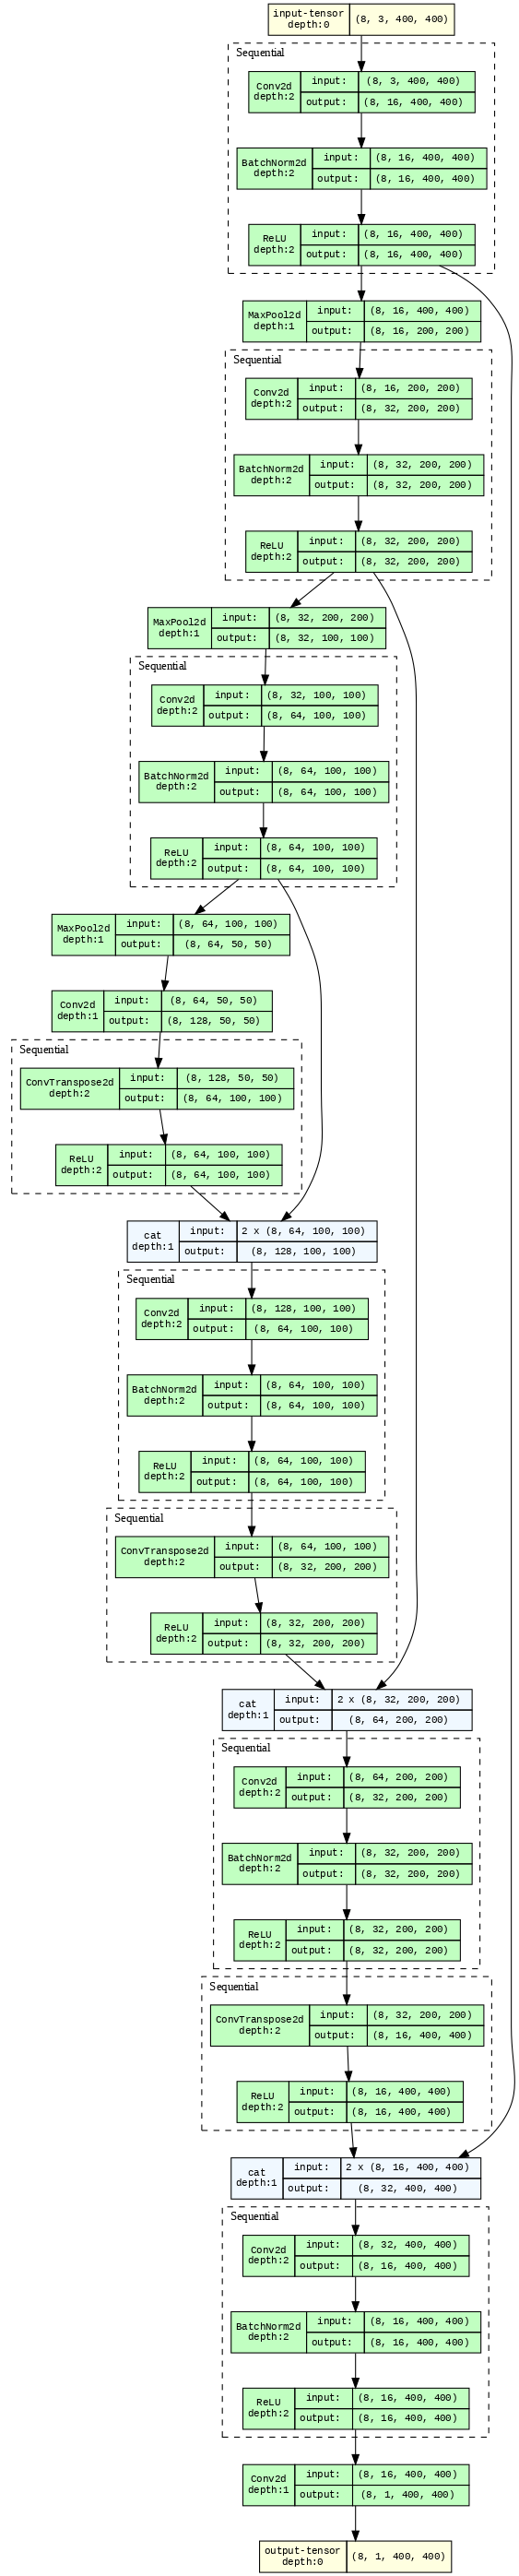

In [ ]:
model_graph = draw_graph(
    unet, input_size=(8,3,400,400), expand_nested=True, save_graph=True, filename=MODEL_FOLDER / Path("model_arch")
)
model_graph.visual_graph

## 5. Define a training loop and train our model;

We have everything prepared in our pipeline; we lack a training loop that will feed data from the data loader to our model, use the model's prediction to compute loss, and update the model's parameter.

First, we import the necessary libraries.

In [ ]:
# If necessary install monai
!python -m pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 53.9 MB/s eta 0:00:00


In [ ]:
from torch import optim
from torchsummary import summary
import monai
from monai.losses import DiceLoss, DiceFocalLoss
import cv2

Secondly, we define a loss function which we want to optimize. Those loss functions were calculated by comparing the model's prediction with the ground-truth segmentation mask. To optimize those loss functions is to produce better segmentation masks.

Below, we made available the following losses:

- [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss)
- [BCE](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss)
- [DiceLoss](https://docs.monai.io/en/stable/losses.html)
- [DiceFocalLoss](https://docs.monai.io/en/stable/losses.html#dicefocalloss)

> See our slide decks and the link provided for further details.

In [ ]:
loss_fuctions = {
    "mse": nn.MSELoss(),
    "bce": nn.BCELoss(),
    "dice": DiceLoss(),
    "dice_focal": DiceFocalLoss()
}

Finally, we define our training loop. For such, we must provide:

- The number of epochs to train our model;
- Our U-Net model;
- A data loader;
- The loss_function (e.g., "mse," "bce");
- Our learning rate (lr), which controls the size of updates in the models' parameters. A too-high value will cause instability, while a too-low value will result in slower training;

> The `n_save_activations` variable controls when we save our convolution activations. Currently, it writes activations for every 200 epochs. However, saving activations is time-consuming, so it could delay the training process. Set it to `n_save_activations=None` to turn off saving activations.

In [ ]:
def train_loop(
    epochs, model, dataloader, lr, loss_function, n_save_activations=200
):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(DEVICE)
    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(epochs):
        losses = []
        accuracies = []
        for batch in dataloader: # In our case, a single image, or 3
            model.train()
            image, ground_truth = batch
            image = image.to(DEVICE)
            ground_truth = ground_truth.to(DEVICE)
            prediction = model(image)
            optimizer.zero_grad()

            # Computes loss and accuracy
            prediction = torch.sigmoid(prediction)
            loss_value = loss_function(prediction, ground_truth)

            accuracy = (
               (prediction > 0.5) == ground_truth
            ).float().mean()
            losses.append(loss_value)
            accuracies.append(accuracy)

            loss_value.backward()
            optimizer.step()

        mean_loss = torch.mean(torch.Tensor(losses))
        mean_acc = torch.mean(torch.Tensor(accuracies))

        print(f"[{epoch + 1}/{epochs}] Avg Loss: {mean_loss.item()} | Avg Accuracy: {mean_acc.item()}")

        epoch_losses.append(mean_loss.item())
        epoch_accuracies.append(mean_acc.item())

        # Each 10 epoch verifyies if the model improved
        if ((epoch + 1) % 10) == 0:
            if epoch_losses[-1] < epoch_losses[-10]:
                model.save_model_weights(
                    epoch+1, epoch_losses[-1], epoch_accuracies[-1]
                )

        if model.activations_path != None:
            if ((epoch + 1) % n_save_activations) == 0:
                model.save_activations(epoch, dataloader)

    model.save_curves(epoch_losses, epoch_accuracies)

Then, we run our training loop, using the training data loader defined before:

In [ ]:
train_loop(
    epochs=EPOCHS,
    model=unet,
    dataloader=train_dataloader,
    lr=LR,
    loss_function=loss_fuctions[LOSS],
)

[1/50] Avg Loss: 1.1290706396102905 | Avg Accuracy: 0.8489468097686768
[2/50] Avg Loss: 0.9174562096595764 | Avg Accuracy: 0.9725717902183533
[3/50] Avg Loss: 0.7106407284736633 | Avg Accuracy: 0.9797980785369873
[4/50] Avg Loss: 0.5385533571243286 | Avg Accuracy: 0.9885650277137756
[5/50] Avg Loss: 0.4917278289794922 | Avg Accuracy: 0.9848912358283997
[6/50] Avg Loss: 0.4371272921562195 | Avg Accuracy: 0.9865179061889648
[7/50] Avg Loss: 0.4092172086238861 | Avg Accuracy: 0.9883124828338623
[8/50] Avg Loss: 0.4009898006916046 | Avg Accuracy: 0.9903530478477478
[9/50] Avg Loss: 0.4087257981300354 | Avg Accuracy: 0.9889421463012695
[10/50] Avg Loss: 0.4259451627731323 | Avg Accuracy: 0.9838932752609253
[11/50] Avg Loss: 0.43879637122154236 | Avg Accuracy: 0.9876725673675537
[12/50] Avg Loss: 0.4471115469932556 | Avg Accuracy: 0.9872921705245972
[13/50] Avg Loss: 0.39660146832466125 | Avg Accuracy: 0.9895455837249756
[14/50] Avg Loss: 0.38305556774139404 | Avg Accuracy: 0.990089952945709

## 6. Define a testing loop, load our best model, and test it.

First, we import the necessary libraries

In [ ]:
# If necessary install medpy and torchmetrics
!python -m pip install medpy
!python -m pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.4/891.4 kB 43.3 MB/s eta 0:00:00


In [ ]:
from medpy.metric import binary
from torchmetrics import JaccardIndex
np.bool = np.bool_

The cells below define a method for using our trained model and predicting a segmentation map. We also compute metrics between the prediction map and the ground truth. The following metrics were used:

- [Accuracy](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html);
- [Dice](http://loli.github.io/medpy/generated/medpy.metric.binary.dc.html#medpy.metric.binary.dc);
- [Intersection-over-Union](https://torchmetrics.readthedocs.io/en/stable/classification/jaccard_index.html), also know as jaccard_index.

> It will also save the predictions to the `MODEL_FOLDER` folder.

In [ ]:
# This code gets the trained model and execute inferences on the Dataloader
@torch.no_grad()
def predict_and_evaluate(
        model: UNet,
        data_loader:torch.utils.data.dataloader.DataLoader
    ):
    images_path = data_loader.dataset.images_path
    labels_path = data_loader.dataset.labels_path
    folder_to_save = model.model_folder / Path("0_preds")
    os.makedirs(folder_to_save, exist_ok=True)

    accuracies = []
    dices = []
    ious = []
    jaccard_index = JaccardIndex(num_classes=2, task="binary")

    for image_path, label_path in tqdm(zip(images_path, labels_path)):
        image_data = data_loader.dataset.image_transforms(Image.open(image_path))
        ground_truth = data_loader.dataset.label_transforms(
            ImageOps.grayscale(Image.open(label_path))
        )
        ground_truth = ground_truth.cpu().detach().numpy()[0]
        # Adds batch dimension
        image_data = torch.unsqueeze(image_data, dim=0)
        image_data = image_data.to(DEVICE)
        prediction = model(image_data)
        prediction = torch.sigmoid(prediction)

        image_name = os.path.basename(image_path)
        path_to_save = folder_to_save / Path(image_name)
        mask = np.zeros((400, 400), dtype=np.uint8)
        prediction = prediction.cpu().detach().numpy().squeeze()
        mask[prediction > 0.5] = 1

        accuracy = np.mean((mask == ground_truth).astype(np.float32))
        accuracies.append(accuracy)
        # Verifies if there is parasite eggs on images
        if np.any(ground_truth > 0):
            dice = binary.dc(mask, ground_truth)
            dices.append(dice)
            iou = jaccard_index(torch.Tensor(mask).long(), torch.Tensor(ground_truth).long())

            ious.append((iou.numpy()))
        else: # If not
            # If there is no parasite and our model predicted it, dice and iou equals 0
            if np.any(mask > 0):
                dices.append(0)
                ious.append(0)
            # If there is no parasite and our model do not predicted it, dice and iou equals 1 (100%)
            else:
                dices.append(1)
                ious.append(1)


        cv2.imwrite(
            str(path_to_save), mask * 255
        )

    accuracies = np.array(accuracies)
    dices = np.array(dices)
    ious = np.array(ious)

    print(f"[INFO] Avg Accuracy: {np.mean(accuracies)} +/- {np.std(accuracies)}")
    print(f"[INFO] Avg Dice: {np.mean(dices)} +/- {np.std(dices)}")
    print(f"[INFO] Avg IoU: {np.mean(ious)} +/- {np.std(ious)}")

Now, we can load the best-trained model and assess our results on both training and test data.

First, let us load our best weights:

In [ ]:
unet.load_best_model()

Load weights from epoch_40_loss_0.318_0.993.pth


Finally, we run our testing method (`predict_and_evaluate`) for the trained model, using the training and testing data.

In [ ]:
print("[INFO] Training Metrics")
predict_and_evaluate(model=unet, data_loader=train_dataloader)

[INFO] Training Metrics


70it [00:06, 11.65it/s]

[INFO] Avg Accuracy: 0.9918951988220215 +/- 0.008278529159724712
[INFO] Avg Dice: 0.8591248108595488 +/- 0.12574022033742757
[INFO] Avg IoU: 0.7704748511314392 +/- 0.15937931835651398


In [ ]:
print("[INFO] Test Metrics")
predict_and_evaluate(model=unet, data_loader=test_dataloader)

[INFO] Test Metrics


30it [00:01, 16.55it/s]

[INFO] Avg Accuracy: 0.9904327392578125 +/- 0.011153306812047958
[INFO] Avg Dice: 0.8532845096940217 +/- 0.14014945473716858
[INFO] Avg IoU: 0.7650221586227417 +/- 0.1732780635356903


As we saw previously, Dice and IoU scores are more suitable for assessing segmentation performance. Analyzing those metrics shows that our model performed better on training data than on testing data. This behavior suggests overfitting, where the model learns its parameters to adjust to the training data and cannot generalize well to unseen data. To solve this problem, we have some approaches. Examples are:

- We could simplify our model so it does not learn a function that over-adjusts to the training data;
- We could augment our training data by increasing the training size. We could force our model to learn more discriminative images by feeding different images. We will learn about augmentations in the classification notebooks.

# Extra - Activities

- Experiment overfitting (training with only one image). What happens?
- Experiment with simplifying the model (fewer filters and smaller filters) and verify your results.
    - Explore different sizes of kernels and visualize the model's activations and improvements on performance metrics
    - Explore different numbers of kernels and visualize the model's activation and improvements in performance metrics
- Explore different losses and classes' weights to improve performance metrics (DICE and IoU)

If you visualize the activations generated by our convolutinal blocks, you will visualize something similar to the image below (for image 000001.png).

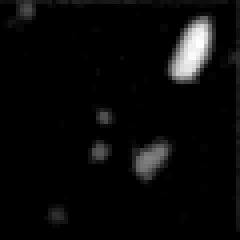

Compare with the activations generated by FLIM (Notebook `2_flim_classification.ipynb`)